## YOLO + microsam prediction

Import Yolo and setup paths

In [1]:
import numpy as np
import napari
print("Napari version:", napari.__version__)
from pathlib import Path
from segment_everything.weights_helper import get_weights_path
from segment_everything.object_detectors.yolo_detector import YoloDetector

Napari version: 0.6.6


/home/bnorthan/code/i2k/tnia/reproducible-dl-seg-article/pixi/microsam_cellposesam/.pixi/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bnorthan/code/i2k/tnia/reproducible-dl-seg-article/pixi/microsam_cellposesam/.pixi/envs/default/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/bnorthan/code/i2k/tnia/reproducible-dl-seg-article/pixi/microsam_cellposesam/.pixi/envs/default/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} 

### Load test image

In [2]:
tnia_images_path = Path(r"D:\images")
tnia_images_path = Path(r"/home/bnorthan/images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2025_05_10_SOTA_Test_Set')

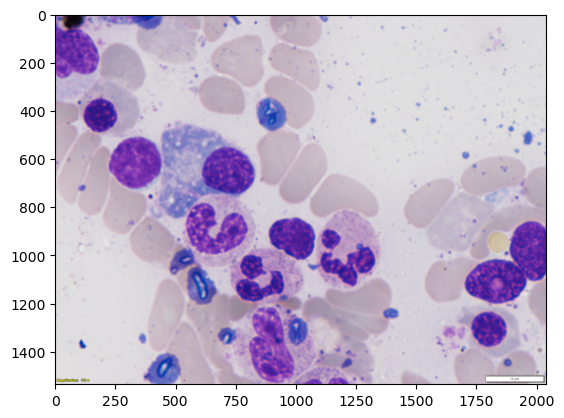

In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt

img = imread(parent_path / r"TestHidden_005.bmp")

# create grayscale only for napari display (temporary napari bug with RGB + 3D labels)
img_grayscale = img.mean(axis=2).astype(np.uint8)

# show original image with matplotlib
plt.imshow(img)

Set up a bounding box detector.  Here I use a Yolo detector vendored from mobilesam, but any bounding box detector would work for this step. 

In [4]:
weights_path = str(get_weights_path("ObjectAwareModel"))
weights_path = str(get_weights_path("ObjectAwareModelHuggingFace"))
yolo_detector_object_aware = YoloDetector(weights_path, "ObjectAwareModelFromMobileSamV2", device='cuda')

Generate bounding boxes with YOLO

In [5]:
results = yolo_detector_object_aware.get_results(img, conf=0.2, imgsz=2048)


0: 1568x2048 106 objects, 296.1ms
Speed: 15.4ms preprocess, 296.1ms inference, 55.5ms postprocess per image at shape (1, 3, 2048, 2048)
0: 1568x2048 106 objects, 296.1ms
Speed: 15.4ms preprocess, 296.1ms inference, 55.5ms postprocess per image at shape (1, 3, 2048, 2048)


Get the classes and the bounding boxes from the Yolo result.  Convert bbox to Napari and Microsam format. 

In [6]:
classes = results[0].boxes.cls.cpu().numpy()

# get xyxy boxes
bboxes_yolo=results[0].boxes.xyxy.cpu().numpy()

# convert to [[y1,x1], [y2,x2]] for napari and [x1,y1,x2,y2] for microsam
bboxes_microsam = []
boxes_napari = []
for box in bboxes_yolo:
    bbox_napari = [[box[1], box[0]], [box[3], box[2]]]
    boxes_napari.append(bbox_napari)
    bbox_microsam = [box[1], box[0], box[3], box[2]]
    bboxes_microsam.append(bbox_microsam)

In [7]:
from micro_sam.sam_annotator._state import AnnotatorState
from micro_sam.sam_annotator.util import prompt_segmentation
from micro_sam import prompt_based_segmentation


In [8]:
state = AnnotatorState()
state.reset_state()
state.initialize_predictor(
    img,
    model_type="vit_b_lm",
    ndim=2,
    #save_path=self.embedding_save_path,
)
        


Compute Image Embeddings 2D: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


In [9]:
# import stacked labels
from segment_everything.stacked_labels import StackedLabels

# Generate masks from bounding boxes
mask_list = []

for bbox_microsam in bboxes_microsam:
    bbox_ = np.array(bbox_microsam)
    prediction =  prompt_based_segmentation.segment_from_box(
        state.predictor, bbox_, image_embeddings=state.image_embeddings)
    
    prediction = np.squeeze(prediction)
    
    mask = StackedLabels.create_mask_from_segmentation(prediction)

    mask_list.append(mask)

In [10]:
stacked_labels = StackedLabels(mask_list)
stacked_labels.make_3d_label_image()


In [11]:
viewer = napari.Viewer()
viewer.add_image(img_grayscale, name='image')
viewer.add_labels(stacked_labels.label_image, name='labels', scale=(3,1,1))

<Labels layer 'labels' at 0x7bac702a57d0>

In [ ]:
shapes_layer = viewer.add_shapes(name='bboxes', face_color= 'transparent', edge_color='green', edge_width=3)

for bbox_microsam in boxes_napari:
    shapes_layer.add_rectangles([bbox_microsam])

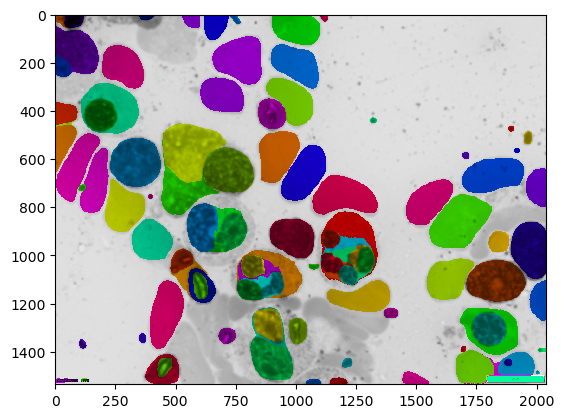

In [22]:
from tnia.plotting.plt_helper import mask_overlay


test = stacked_labels.make_2d_labels(type="max")

plt.imshow(mask_overlay(img, test))

In [29]:
# append empty zero slice to labels 

temp = np.zeros((1, viewer.layers['labels'].data.shape[1], viewer.layers['labels'].data.shape[2]))
temp = temp.astype(viewer.layers['labels'].data.dtype)

viewer.layers['labels'].data = np.concatenate([viewer.layers['labels'].data, temp], axis=0)
